In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from typing import NamedTuple, List, Tuple, Dict
import keras
import tensorflow as tf

np.set_printoptions(precision=5, linewidth=200)

Regression Min Val: 0.14999
Train Regression Min Val count: 9.0
Regression Max Val: 5.00001
Train `Regression Max Val count: 1827.0
         MedInc   HouseAge  AveRooms  AveBedrms   Population  AveOccup  \
mu     3.851029  26.057005  5.163124   1.062204  1660.778919  2.831243   
sigma  1.803167  12.158221  1.206242   0.096490  1302.469608  2.702413   

        Latitude   Longitude    RegVal  Label  
mu     35.570030  119.554329  2.079751    0.0  
sigma   2.083179    1.974028  1.158571    0.0  


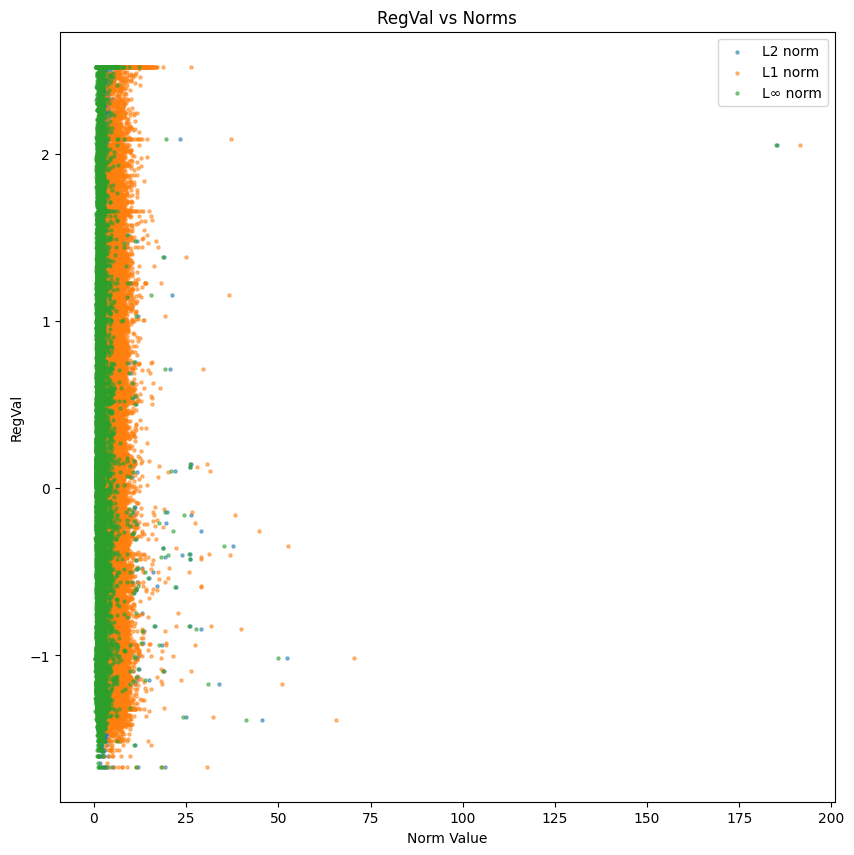

L1: rejected=2867, kept=34270/37137 (92.28%)
L2: rejected=116, kept=37021/37137 (99.69%)
L∞: rejected=108, kept=37029/37137 (99.71%)
Data Points Kept: 37021


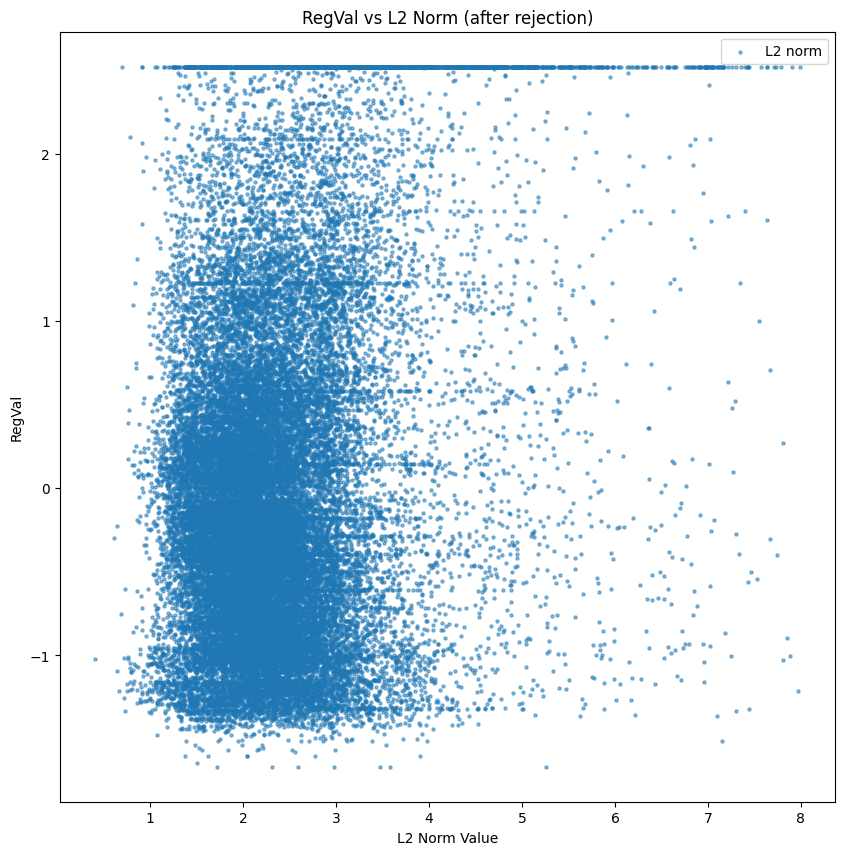

In [2]:
test_data = pd.read_csv("regression-tabular-california-housing/test.csv", header= 0, index_col= 0)
test_data["Longitude"] = test_data["Longitude"].abs() # longitudes are all negative, so problematic for log, take abs
data_cols = test_data.columns

train_data = pd.read_csv("regression-tabular-california-housing/train.csv", header= 0, index_col=0)
train_data["RegVal"] = train_data["MedHouseVal"]
train_data = train_data.drop(columns = ["MedHouseVal"])
train_data["Longitude"] = train_data["Longitude"].abs() # longitudes are all negative, so problematic for log, take abs

reg_max_val = train_data["RegVal"].max() # maximum regression values
train_data["Label"] = (train_data["RegVal"] == reg_max_val).astype(float)# for classification.

# print the minimum of train 's regVals before the transform
reg_min_val = train_data["RegVal"].min()
print(f"Regression Min Val: {reg_min_val}")
print(f"Train Regression Min Val count: {(train_data['RegVal'] == reg_min_val).astype(float).sum()}")

print(f"Regression Max Val: {reg_max_val}")
print(f"Train `Regression Max Val count: {(train_data['RegVal'] == reg_max_val).astype(float).sum()}")


def transform_data(x: np.ndarray):
    y = x
    # y = np.log(x)
    mu = np.mean(y)
    sigma = np.std(y, ddof=1)  # sample std
    y = (y - mu) / sigma
    return y, mu, sigma

def invert_transform(y: np.ndarray, mu: float, sigma: float): 
    # return np.exp(y * sigma + mu)
    return y * sigma + mu

stats_data = pd.DataFrame(0.0, index=["mu", "sigma"], columns=train_data.columns,dtype=float)

# Transform data and store mu and sigma
for col in data_cols:
    
    # transform train col
    col_y, col_mu, col_sigma = transform_data(train_data[col].to_numpy())
    train_data[col] = col_y

    # apply the *same* log + z-score to test col
    test_data[col] = (test_data[col].to_numpy() - col_mu) / col_sigma

    # store stats
    stats_data.loc["mu", col] = col_mu
    stats_data.loc["sigma", col] = col_sigma
    

# Log  Normalize Regression Values
reg_y, reg_mu, reg_sigma = transform_data(train_data["RegVal"].to_numpy())
train_data["RegVal"] = reg_y
stats_data.loc["mu", "RegVal"] = reg_mu
stats_data.loc["sigma", "RegVal"] = reg_sigma

print(stats_data)

# plot norm vs training RegVal
X = train_data.loc[:, data_cols].to_numpy(dtype=float)
# --- norms ---
l2_norm = np.sqrt(np.sum(X**2, axis=1))
l1_norm = np.sum(np.abs(X), axis=1)
linf_norm = np.max(np.abs(X), axis=1)

plt.figure(figsize=(10, 10))
plt.scatter(l2_norm, train_data["RegVal"], s=5, alpha=0.5, label="L2 norm")
plt.scatter(l1_norm, train_data["RegVal"], s=5, alpha=0.5, label="L1 norm")
plt.scatter(linf_norm, train_data["RegVal"], s=5, alpha=0.5, label="L∞ norm")
plt.xlabel("Norm Value")
plt.ylabel("RegVal")
plt.title("RegVal vs Norms")
plt.legend()
plt.show()

# Rejection Criteria
rejection_threshold = 8

for name, arr in [("L1", l1_norm), ("L2", l2_norm), ("L∞", linf_norm)]:
    kept = np.sum(arr < rejection_threshold)
    total = len(arr)
    rejected = total - kept
    perc_kept = 100 * kept / total
    print(f"{name}: rejected={rejected}, kept={kept}/{total} ({perc_kept:.2f}%)")

# Apply mask row-wise
keep = l2_norm < rejection_threshold
train_data = train_data.loc[keep].reset_index(drop=True)

# Recompute X on filtered data
X = train_data.loc[:, data_cols].to_numpy(dtype=float)
print("Data Points Kept:", len(train_data))

# Recompute L2 on kept X
l2_norm = np.sqrt(np.sum(X**2, axis=1))
plt.figure(figsize=(10, 10))
plt.scatter(l2_norm, train_data["RegVal"], s=5, alpha=0.5, label="L2 norm")
plt.xlabel("L2 Norm Value")
plt.ylabel("RegVal")
plt.title("RegVal vs L2 Norm (after rejection)")
plt.legend()
plt.show()


In [3]:
""" PCA , calculate the projection matrix """
train_cov = train_data.loc[:, data_cols].cov().to_numpy()
eigen_vals, eigen_vecs = np.linalg.eig( train_cov)

eigen_pairs = [ (val, vec.T) for val, vec in zip(eigen_vals, eigen_vecs) ]
eigen_pairs.sort(key = lambda x: x[0], reverse=True)

eigen_variance = np.array( [val for val, vec in eigen_pairs] )
eigen_variance = eigen_variance / np.sum(eigen_variance)

# Determine dimensions using min variance threshold
min_variance = 1

curr_variance = 0
keep_dims = 0
for var in eigen_variance:
    if curr_variance >= min_variance: break
    curr_variance += var
    keep_dims += 1

eigen_pairs = eigen_pairs[:keep_dims]
proj = np.stack( [ vec for val, vec in eigen_pairs], axis = 1)
print(proj)
print(proj.shape)


[[-0.12764 -0.05964 -0.19665  0.01075  0.09413  0.02328 -0.68728 -0.67794]
 [ 0.69118 -0.25472  0.63977 -0.06394  0.05244  0.00734 -0.12565 -0.15939]
 [ 0.19869  0.79732  0.08699 -0.11092 -0.52957 -0.00854 -0.06567 -0.14178]
 [ 0.15928  0.4689  -0.07116 -0.29292  0.81027  0.03656  0.07547 -0.018  ]
 [-0.06442  0.25704  0.23805  0.90835  0.21654 -0.00891 -0.03219 -0.00274]
 [ 0.62938 -0.08745 -0.67425  0.2635  -0.05152 -0.13583  0.19266 -0.11818]
 [-0.18341 -0.04495  0.14056 -0.01238 -0.01019  0.02952  0.68067 -0.69293]
 [ 0.08502 -0.0155  -0.09137  0.05482 -0.04194  0.98924  0.0196   0.02101]]
(8, 8)


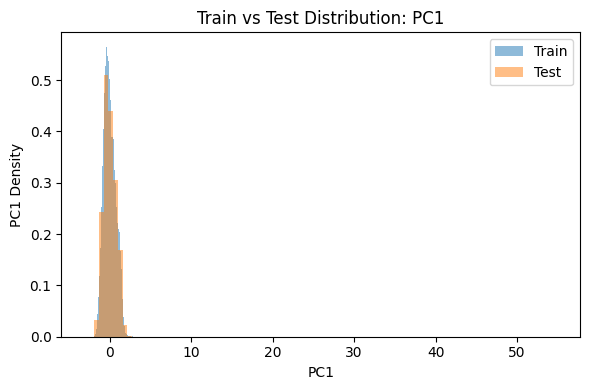

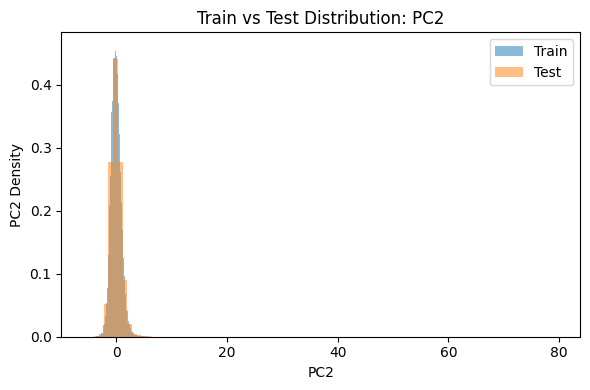

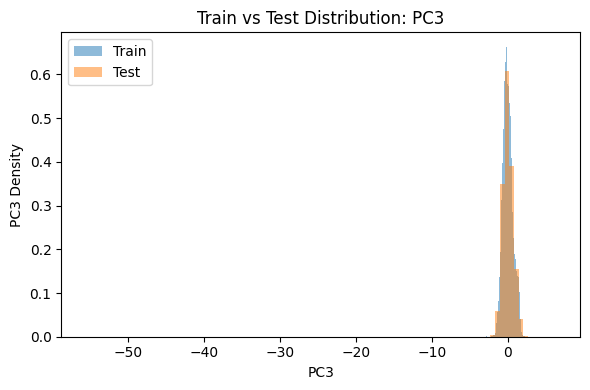

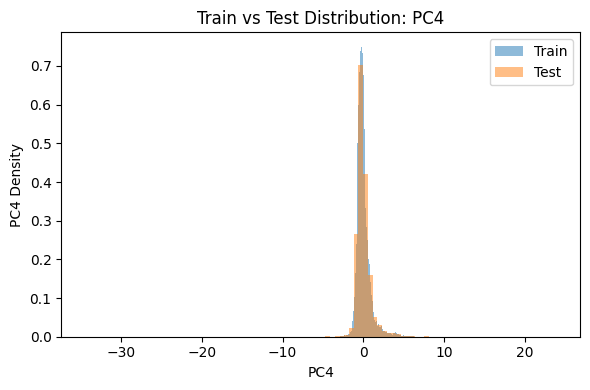

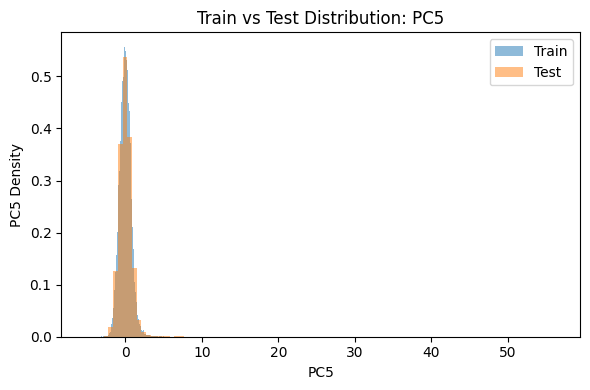

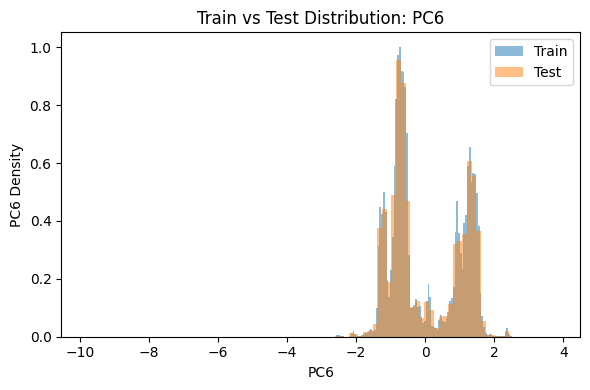

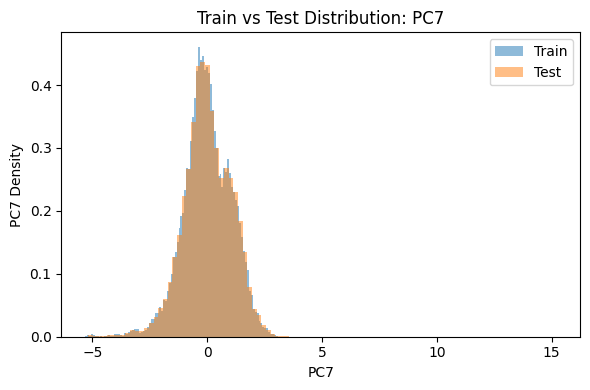

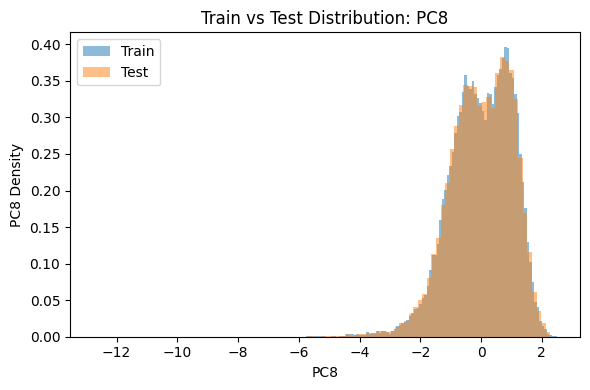

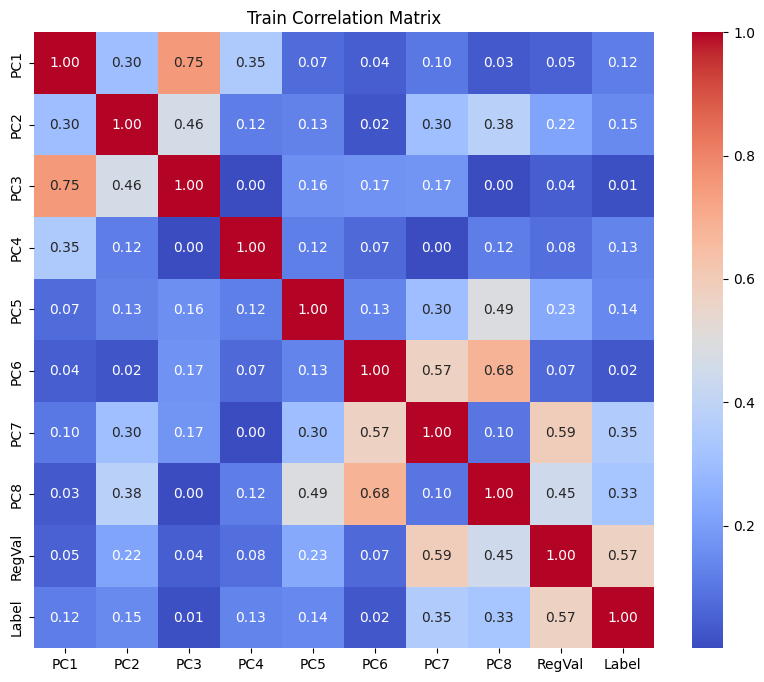

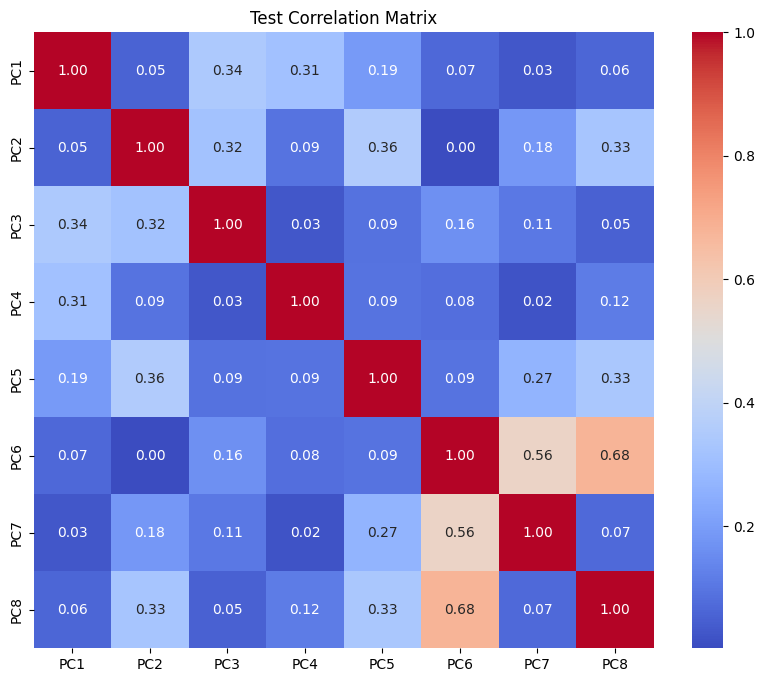

In [4]:
# project the training data down
train_projected = train_data.loc[:, data_cols].to_numpy() @ proj

train_regval = train_data["RegVal"].copy()  # save before overwriting
train_label = train_data["Label"].copy()

train_data = pd.DataFrame( train_projected,
    index=train_data.index,
    columns=[f"PC{i+1}" for i in range(train_projected.shape[1])]
)

train_data["RegVal"] = train_regval  # restore
train_data["Label"] = train_label  # restore


# project the test data down
test_projected = test_data.to_numpy() @ proj
test_data = pd.DataFrame(test_projected,index=test_data.index,columns=[f"PC{i+1}" for i in range(test_projected.shape[1])])
data_cols = test_data.columns # reset the data_cols


""" Plot some histograms """
for col in data_cols:
    plt.figure(figsize=(6, 4))
    # plt.yscale("log")   # set y-axis to log scale
    plt.hist(train_data[col], bins=100, alpha=0.5, label="Train", density=True)
    plt.hist(test_data[col], bins=100, alpha=0.5, label="Test", density=True)
    plt.title(f"Train vs Test Distribution: {col}")
    plt.xlabel(col)
    plt.ylabel(f"{col} Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

""" Plot train and test correlation matrix """
train_corr = train_data.corr().abs()
test_corr = test_data.corr().abs()

# Plot train correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Train Correlation Matrix")
plt.show()

# Plot test correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_corr, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Test Correlation Matrix")
plt.show()

In [5]:
""" Creating the training, validation and test sets """
k_fold = 10

kf = KFold(n_splits=k_fold, shuffle=True, random_state=42)

folds_tensors = []

for train_idx, valid_idx in kf.split(train_data):
    
    train = train_data.iloc[train_idx]
    validation = train_data.iloc[valid_idx]
    
    train_X = tf.convert_to_tensor(train.loc[:, data_cols].to_numpy(), dtype=tf.float32)
    train_y = tf.convert_to_tensor(train.loc[:, ["RegVal", "Label"]].to_numpy(), dtype=tf.float32)
    val_X   = tf.convert_to_tensor(validation.loc[:, data_cols].to_numpy(), dtype=tf.float32)
    val_y   = tf.convert_to_tensor(validation.loc[:, ["RegVal", "Label"]].to_numpy(), dtype=tf.float32)
    folds_tensors.append( ( train_X,train_y, val_X,val_y ) )

    print(f"Training X: {train_X.shape}, Training Y:{train_y.shape}")
    print(f"Validation X: {val_X.shape}, Validation Y:{val_y.shape}")
    
folds_tensors = tuple(folds_tensors) # oconvert to tuple

Training X: (33318, 8), Training Y:(33318, 2)
Validation X: (3703, 8), Validation Y:(3703, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)
Training X: (33319, 8), Training Y:(33319, 2)
Validation X: (3702, 8), Validation Y:(3702, 2)


In [6]:
""" Supervised Training """

input_size = len(data_cols)
num_epochs = 300
iterations_per_fold = 50
total_iterations = num_epochs * k_fold * iterations_per_fold
lr_start = 0.0005
lr_end = 0.00001
batch_size = 128
regularization = keras.regularizers.l2(2e-3)
droput_val = 0.07


""" Creating the Regression Network (Functional) """
# Input
inp = keras.Input(shape=(input_size,), name="input")

# Hidden layers (loop)
x = inp
for i in range(7):
    if i!= 0: prev_x = x
    x = keras.layers.Dense(256, kernel_regularizer=regularization)(x)
    x = keras.layers.LayerNormalization()(x) 
    x = keras.layers.Activation("gelu")(x)
    x = keras.layers.Dropout(rate=droput_val)(x)  # optional
    if i!= 0: x = x + prev_x  # residual
        

# Regression head
reg_out = keras.layers.Dense(1, kernel_regularizer=regularization, bias_initializer="zeros", activation=None)(x)

# Build model
regression_network = keras.Model(inputs=inp, outputs=reg_out, name="functional_net_with_cap_head")
regression_network.summary()

""" Regression Network Created"""

# Using a customized LR schedule that is geometrically spaced instead of linearly spaced
class GeometricLRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_start, lr_end, total_steps):
        super().__init__()
        self.lr_start = lr_start
        self.lr_end = lr_end
        self.total_steps = total_steps
        # compute geometric ratio
        self.r = (lr_end / lr_start) ** (1 / (total_steps - 1))

    def __call__(self, step):
        return self.lr_start * (self.r ** step)

reg_loss_fn = keras.losses.MeanSquaredError()
lr_schedule = GeometricLRSchedule(lr_start, lr_end, total_iterations)
optimizer = keras.optimizers.legacy.Adam(lr_schedule)


Model: "functional_net_with_cap_head"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  2304      ['input[0][0]']               
                                                                                                  
 layer_normalization (Layer  (None, 256)                  512       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256)                  0         ['l

In [7]:
""" Training Loop"""
epoch_losses = tf.Variable(tf.zeros([num_epochs], dtype=tf.float32), trainable=False)

@tf.function
def training_loop(
    folds_tensors,          # sequence (e.g. tuple) of dicts: {"train_X":T,"train_y":T,"val_X":T,"val_y":T}
    neural_network,         # tf.keras.Model or call-able
    optimizer,              # tf.keras.optimizers.Optimizer
    reg_loss_fn,            # Regression Loss functin
    num_epochs,             # Python int or tf.int32 scalar
    k_fold,                 # Python int or tf.int32 scalar
    iterations_per_fold,    # Python int or tf.int32 scalar
    batch_size,             # Python int or tf.int32 scalar
    epoch_losses            # tf.Variable shape (num_epochs,)
):
    # convert changing Python ints into tensors once (avoids some retracing)
    num_epochs_t = tf.convert_to_tensor(num_epochs, dtype=tf.int32)
    k_fold_t = tf.convert_to_tensor(k_fold, dtype=tf.int32)
    iterations_t = tf.convert_to_tensor(iterations_per_fold, dtype=tf.int32)
    batch_size_t = tf.convert_to_tensor(batch_size, dtype=tf.int32)

    for epoch in tf.range(num_epochs_t):
        tf.print("\nEpoch:", epoch, "/", num_epochs_t - 1)
        sum_val_loss = tf.constant(0.0, dtype=tf.float32)

        for train_X,train_y, val_X,val_y  in folds_tensors:
            
            n_train = tf.shape(train_X)[0]
            for _ in tf.range(iterations_t):
                idx = tf.random.uniform([batch_size_t], minval=0, maxval=n_train, dtype=tf.int32)
                x_batch = tf.gather(train_X, idx)
                y_batch = tf.gather(train_y, idx)

                with tf.GradientTape() as tape:
                    reg_pred = neural_network(x_batch, training=True)
                    reg_true = y_batch[:, 0:1]
                    nn_loss_value = reg_loss_fn(reg_true, reg_pred)

                grads = tape.gradient(nn_loss_value, neural_network.trainable_weights)
                optimizer.apply_gradients(zip(grads, neural_network.trainable_weights))

            reg_val_pred = neural_network(val_X, training=False)
            reg_val_true = val_y[:, 0:1]
            val_loss = reg_loss_fn(reg_val_true, reg_val_pred)

            sum_val_loss = sum_val_loss + val_loss
            # tf.print(val_logits)
        avg_nn_val_loss = sum_val_loss / tf.cast(k_fold_t, tf.float32)
        epoch_losses.scatter_nd_update(indices=[[epoch]], updates=[avg_nn_val_loss])
        tf.print("Validation Loss: ", avg_nn_val_loss )

training_loop(folds_tensors, regression_network, optimizer, reg_loss_fn, num_epochs, k_fold, iterations_per_fold, batch_size, epoch_losses)





Epoch: 0 / 299
Validation Loss:  0.377620161

Epoch: 1 / 299
Validation Loss:  0.33560127

Epoch: 2 / 299
Validation Loss:  0.32255426

Epoch: 3 / 299
Validation Loss:  0.324814886

Epoch: 4 / 299
Validation Loss:  0.318235785

Epoch: 5 / 299
Validation Loss:  0.304505795

Epoch: 6 / 299
Validation Loss:  0.307975113

Epoch: 7 / 299
Validation Loss:  0.297915697

Epoch: 8 / 299
Validation Loss:  0.297099978

Epoch: 9 / 299
Validation Loss:  0.291771948

Epoch: 10 / 299
Validation Loss:  0.289105713

Epoch: 11 / 299
Validation Loss:  0.285805106

Epoch: 12 / 299
Validation Loss:  0.286076516

Epoch: 13 / 299
Validation Loss:  0.285793155

Epoch: 14 / 299
Validation Loss:  0.286512733

Epoch: 15 / 299
Validation Loss:  0.281575263

Epoch: 16 / 299
Validation Loss:  0.283756673

Epoch: 17 / 299
Validation Loss:  0.278793216

Epoch: 18 / 299
Validation Loss:  0.28091833

Epoch: 19 / 299
Validation Loss:  0.274067

Epoch: 20 / 299
Validation Loss:  0.283202112

Epoch: 21 / 299
Validation L

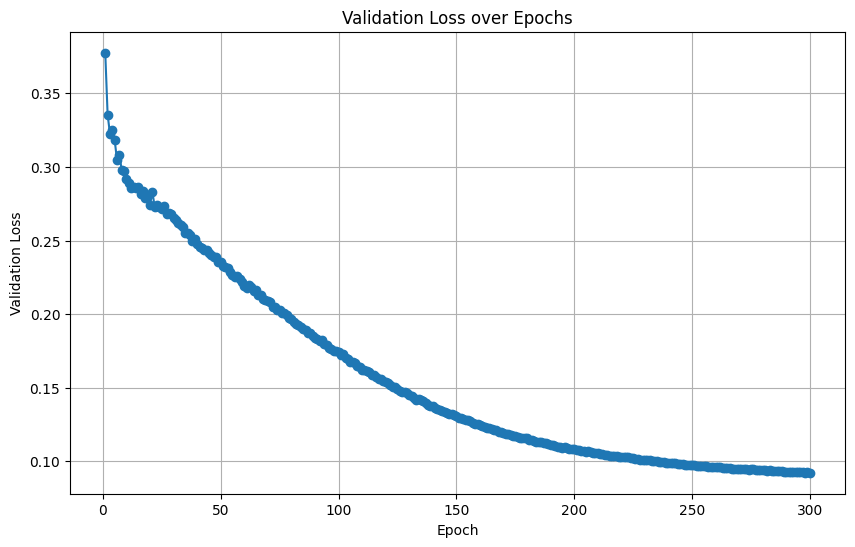

In [8]:
# Plot validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1),  epoch_losses.numpy(), marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss over Epochs")
plt.grid(True)
plt.show()

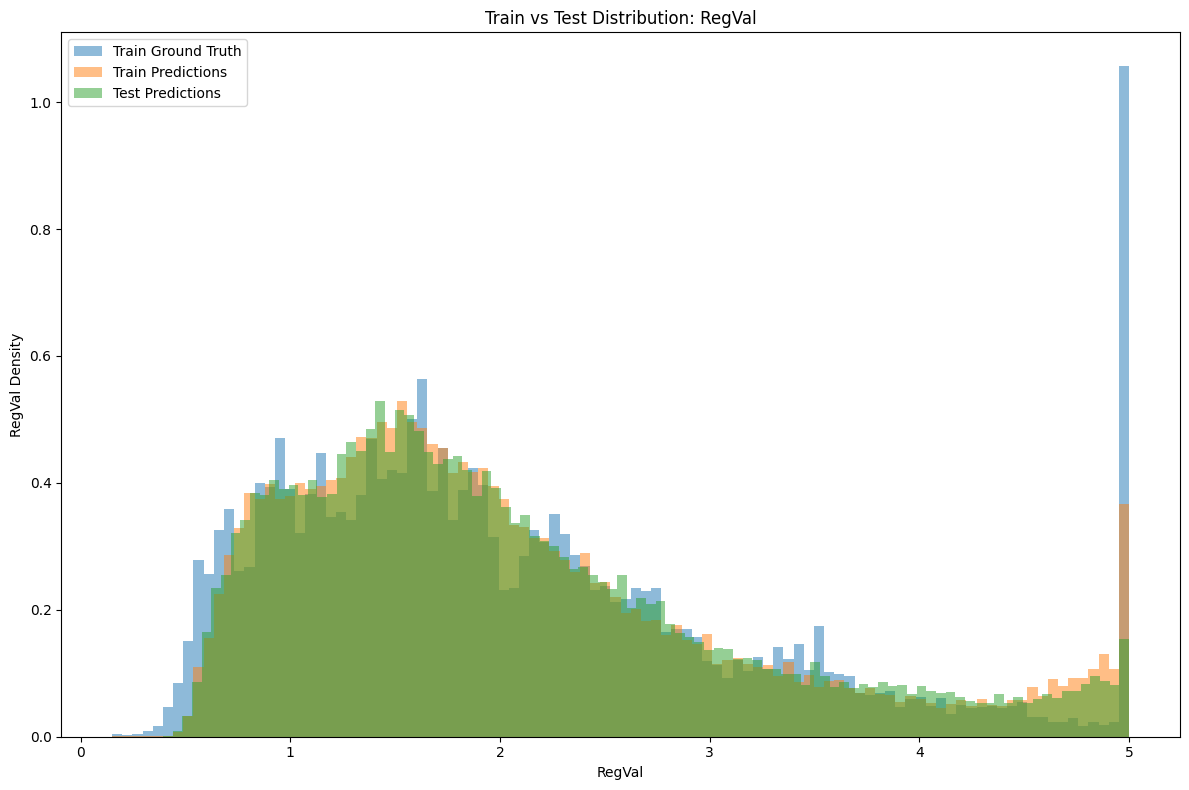

In [9]:
from sklearn.metrics import roc_curve

# Get train predictions
X_train = train_data.loc[:, data_cols].to_numpy()
train_reg_vals = regression_network(X_train, training=False)
train_reg_vals = train_reg_vals.numpy().squeeze()

# Now invert the regression values
train_reg_vals = invert_transform(
    train_reg_vals, 
    stats_data.loc["mu", "RegVal"], 
    stats_data.loc["sigma", "RegVal"]
)
# cap outputs on both edge
train_reg_vals[train_reg_vals > reg_max_val] = reg_max_val
train_reg_vals[train_reg_vals < reg_min_val] = reg_min_val


# Invert train ground truth
train_reg_vals_truth = train_data["RegVal"].to_numpy()
train_reg_vals_truth = invert_transform(
    train_reg_vals_truth, 
    stats_data.loc["mu", "RegVal"], 
    stats_data.loc["sigma", "RegVal"]
)


# Process test data similarly
X_test = test_data.to_numpy()
test_reg_vals = regression_network(X_test, training=False)
test_reg_vals = test_reg_vals.numpy().squeeze()

# Now invert the test regression values
test_reg_vals = invert_transform(
    test_reg_vals, 
    stats_data.loc["mu", "RegVal"], 
    stats_data.loc["sigma", "RegVal"]
)
# cap train predictions outputs on both edge
test_reg_vals[test_reg_vals > reg_max_val] = reg_max_val
test_reg_vals[test_reg_vals < reg_min_val] = reg_min_val

plt.figure(figsize=(12, 8))
plt.hist(train_reg_vals_truth, bins=100, alpha=0.5, label="Train Ground Truth", density=True)
plt.hist(train_reg_vals, bins=100, alpha=0.5, label="Train Predictions", density=True)
plt.hist(test_reg_vals, bins=100, alpha=0.5, label="Test Predictions", density=True)
plt.title(f"Train vs Test Distribution: RegVal")
plt.xlabel("RegVal")
plt.ylabel(f"RegVal Density")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
""" Create the output csv submission.csv """
submission_df = pd.DataFrame({"id":test_data.index, "MedHouseVal": test_reg_vals})
submission_df.to_csv("regression-tabular-california-housing/submission.csv", index=False)